# Air-Sea Interactions Group
OOI Data Labs Workshop - June 2019

**Working Title**: Dynamic Air-Sea Interactions

**Short Description**: 
* Exploration: Students will explore and analyze wave height and wave period using graphs, and hypothesize possible causation.
* Application #1: Students will explore and analyze wave properties, in addition to surface current speed and wind speed, using graphs, and hypothesize possible correlation and causation.
* Application #2: Students will explore and analyze wave properties, surface current speed, wind speed, and atmospheric pressure using graphs, and hypothesize possible correlation and causation. Students will predict precipitation amounts in relation to atmospheric pressure and reflect on impacts of episodic events on coastal communities. 

**Your Objective** (Challenge Question): 
* Exploration: How do atmospheric processes affect surface oceanographic conditions?
* Application #1: How do atmospheric processes affect surface oceanographic conditions?
* Application #2: How do atmospheric processes affect surface oceanographic conditions?


In [0]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt

# Setup default plot styles
import seaborn as sns
sns.set()

## 1. Request Data from OOINet

* **Time range:** 2018-01-01 00:00:00 to 2018-01-07 00:00:00
* **Waves:** Coastal Pioneer, Central Surface Mooring, Surface Wave Spectra (CP01CNSM-SBD12-05-WAVSSA000) recovered_host, wavss_a_dcl_statistics_recovered
  * Time series of maximum wave height and peak wave period, line plotted on a single figure. 
* **Winds and Currents:** Coastal Pioneer, Inshore Surface Mooring, Bulk Meteorology Instrument (CP03ISSM-SBD11-06-METBKA000), recovered_host, metbk_a_dcl_instrument_recovered
  * Why not Central Surface Mooring CP01CNSM-SBD11-06-METBKA000 or CP01CNSM-SBD12-06-METBKA000?
  * **Application #1:** Begin with single time-series plot of maximum wave height and peak wave period, line plot, same figure as in Exploration 1. Clicking the Next button will sequentially add single time-series plots of relative wind speed and surface current speed (both from CP Inshore), each one below the previous figure. Three stacked figures total. Each plot a different color.
  * **Application #2:** Begin with four time-series plots, stacked vertically. On top,  maximum wave height and peak wave period, line plot, same figure as in Exploration 1. Below that, the wind speed and surface current plots from Application 1. Below that, a time-series plot with two variables, barometric pressure (mbar) and rain rate (mm/hr). The precipitation data will end at approximately 10:00 am Jan 4, and students will be able to use the cursor to draw in a predicted precipitation curve over the rest of the figure. Clicking a “Check Prediction” button/box will reveal the actual precipitation data. Each plot in a different color (use same color scheme from Application 1). 


In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# Wave Data
# request_data('CP01CNSM-SBD12-05-WAVSSA000','recovered_host','wavss_a_dcl_statistics_recovered',
#              '2018-01-01T00:00:00.000Z','2018-01-07T00:00:00.000Z')

# Met Data
# request_data('CP03ISSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2018-01-01T00:00:00.000Z','2018-01-07T00:00:00.000Z')

# Other Met Data
# request_data('CP01CNSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2018-01-01T00:00:00.000Z','2018-01-07T00:00:00.000Z')
# request_data('CP01CNSM-SBD12-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2018-01-01T00:00:00.000Z','2018-01-07T00:00:00.000Z')


## 2. Load Data Files

In [0]:
url_wave = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190711T202427623Z-CP01CNSM-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/catalog.html'
url_met_CP03ISSM = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190711T202438591Z-CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_met_CP01CNSM11 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190711T202448996Z-CP01CNSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_met_CP01CNSM12 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190711T202459293Z-CP01CNSM-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'


In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  # ds = ds.chunk({'time': 100}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [0]:
# Load the datasets
data_wave = get_data(url_wave)
data_met03 = get_data(url_met_CP03ISSM,'velpt')
data_met11 = get_data(url_met_CP01CNSM11,'velpt')
data_met12 = get_data(url_met_CP01CNSM12,'velpt')

## Data Plots

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


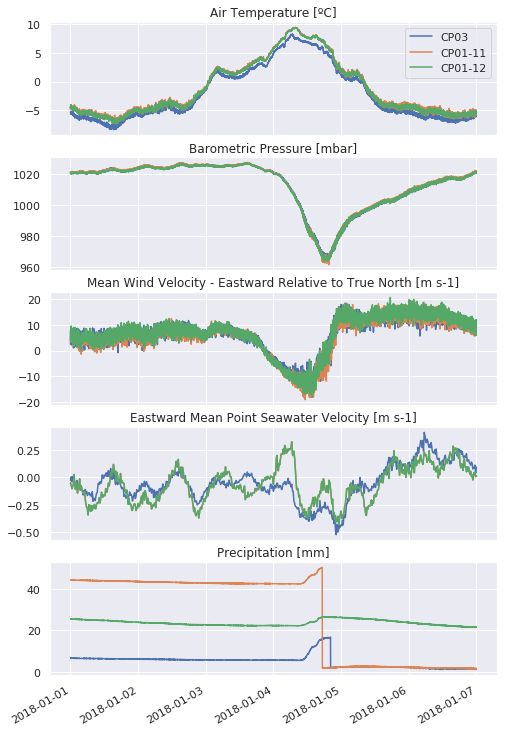

In [0]:
# Let's quickly plot the various METBK options

vars = ['air_temperature','barometric_pressure','met_windavg_mag_corr_east','eastward_velocity','precipitation']

fig,ax = plt.subplots(5,1,sharex=True,figsize=(8,12))
for i,var in enumerate(vars):
  data_met03[var].plot(label='CP03',ax=ax[i])
  data_met11[var].plot(label='CP01-11',ax=ax[i])
  data_met12[var].plot(label='CP01-12',ax=ax[i])
  ax[i].set_xlabel('')
  ax[i].set_ylabel('')
  ax[i].set_title('%s [%s]' % (data_met03[var].long_name,data_met03[var].units));

ax[0].legend()

plt.savefig('cp_met.png')

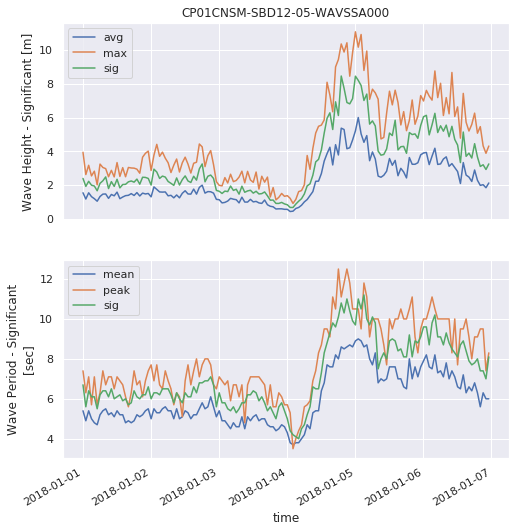

In [0]:
# And the WAVES variables
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(8,8))
data_wave.average_wave_height.plot(label='avg',ax=ax1)
data_wave.max_wave_height.plot(label='max',ax=ax1)
data_wave.significant_wave_height.plot(label='sig',ax=ax1)

data_wave.mean_wave_period.plot(label='mean',ax=ax2)
data_wave.peak_wave_period.plot(label='peak',ax=ax2)
data_wave.significant_period.plot(label='sig',ax=ax2)

ax1.set_xlabel('')
ax1.legend()
ax2.legend()
ax1.set_title('%s-%s-%s' % (data_wave.subsite,data_wave.node,data_wave.sensor));

plt.savefig('cp_waves.png')

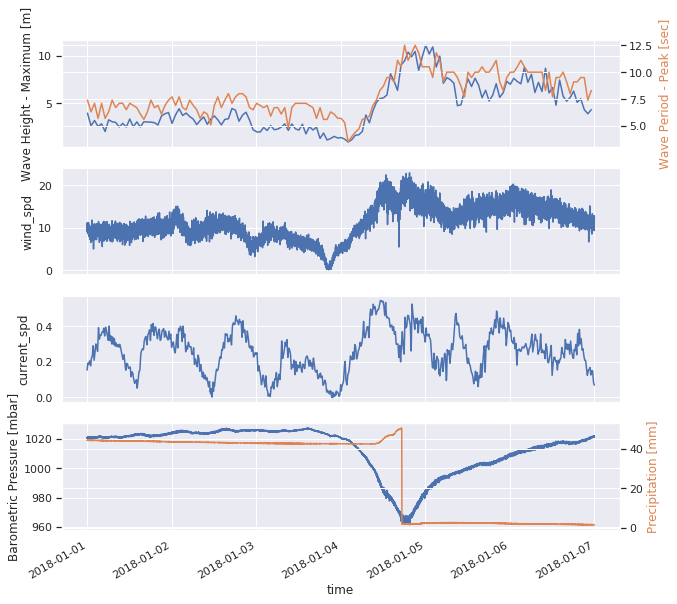

In [0]:
# Plot the data for the activity
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
ax1b = ax1.twinx()
ax4b = ax4.twinx()
altcolor = sns.color_palette()[1]

data_wave.max_wave_height.plot(label='max', ax=ax1)
data_wave.peak_wave_period.plot(label='peak', ax=ax1b, color=altcolor)
ax1b.set_ylabel(ax1b.yaxis.label.get_text() ,color=altcolor)

data_met11['wind_spd'] = (data_met11.met_windavg_mag_corr_east**2 + data_met11.met_windavg_mag_corr_north**2)**0.5
data_met11.wind_spd.plot(ax=ax2)

data_met11['current_spd'] = (data_met11.eastward_velocity**2 + data_met11.northward_velocity**2)**0.5
data_met11['current_spd'].plot(ax=ax3)

data_met11.barometric_pressure.plot(ax=ax4)
data_met11.precipitation.plot(ax=ax4b, color=altcolor)
ax4b.set_ylabel(ax4b.yaxis.label.get_text(), color=altcolor)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');

plt.savefig("airsea.png");

## 3. Merge and export

In [0]:
# Subset the datasets
a = data_met11[['wind_spd','current_spd','barometric_pressure','precipitation']]
b = data_wave[['max_wave_height','peak_wave_period']]

# Resample/average
avgint = '1h' #'15min'
a_avg = a.load().resample(time=avgint).mean()
b_avg = b.load().resample(time=avgint).mean()

# Calculate Daily Precipitation 
rain = data_met11.precipitation.load().resample(time='15min').mean().diff('time')
rain = rain.where(rain>0)
rain = rain.resample(time=avgint).sum()
rain = rain.where(rain<100)
a_avg['rain'] = rain


In [0]:
# Merge the datasets
x = xr.merge([a_avg,b_avg]).to_dataframe()

# Print the first few rows
# x.head()

In [0]:
# Export to CSV
x.to_csv('airsea.csv')

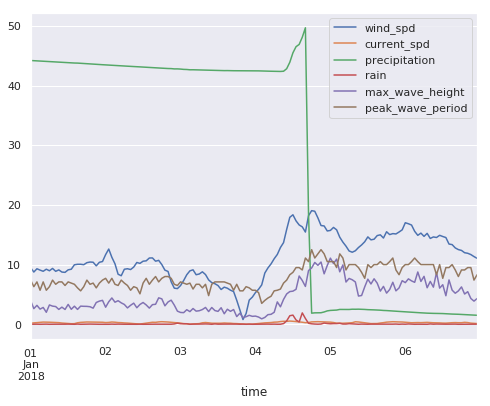

In [0]:
# Quicklook plot
x[['wind_spd','current_spd','precipitation','rain','max_wave_height','peak_wave_period']].plot(figsize=(8,6));

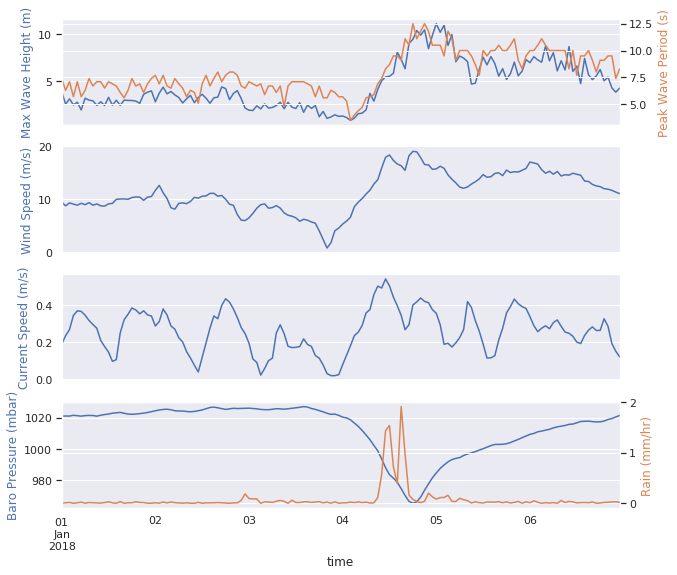

In [0]:
# Final plot
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
ax1b = ax1.twinx()
ax4b = ax4.twinx()
color1 = sns.color_palette()[0]
color2 = sns.color_palette()[1]


x.max_wave_height.plot(label='max', ax=ax1)
x.peak_wave_period.plot(label='peak', ax=ax1b, color=color2)
x.wind_spd.plot(ax=ax2)
x.current_spd.plot(ax=ax3)
x.barometric_pressure.plot(ax=ax4)
x.rain.plot(ax=ax4b, color=color2)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');

ax1.set_ylabel('Max Wave Height (m)',color=color1)
ax1b.set_ylabel('Peak Wave Period (s)',color=color2)
ax2.set_ylabel('Wind Speed (m/s)', color=color1)
ax3.set_ylabel('Current Speed (m/s)', color=color1)
ax4.set_ylabel('Baro Pressure (mbar)', color=color1)
ax4b.set_ylabel('Rain (mm/hr)',color=color2)


plt.savefig("airsea_final.png");

## Questions
1. How did you pick this time period?
2. For Met data, you requested CP03 (inshore) rather than CP01 (central), which corresponds to the wave buoy.  Was there a specific reason? I used CP01 above, to keep it consistant.
3. Do you want rain rate (for some interval) or the raw perciption level?  I've calculated rain rate above.
4. Is a 1hr averaging interval ok?  Would 10-15 minutes be preferable?
5. Do you want other variables?  E.g. air temp, salinity.
6. Do you want to stick with max/peak waves, or perhaps the more commonly used significant waves?
7. Note the storm response to the Eastward winds/currents vs. the absolute value of the speed.  With the component, you can see the dramatic shift as the front moves through, which isn't aparent in the speed. Likewise, the current response is harder to see, because the tides are so strong and the change in direction is hidden. Of course, speed is the driver for waves, so that correlation holds up, and is probably simpler to interpret.
8. Should Application #1 include pressure, or just the two speeds?
9. If we use rain rate, do you still want students to draw this in Application #2, or perhaps they draw something else?
